In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from indigo import *
import numpy as np
from sklearn.metrics import r2_score



In [9]:
indigo = Indigo()
indigo.setOption("ignore-stereochemistry-errors", True)
indigo.setOption("ignore-bad-valence", True)
df = pd.read_csv("Adrenergic_dataset.csv")
df.shape

(1731, 327)

In [3]:
df.head()

,Structure,ID,logP,Vx,MW,NegativeCharge,PositiveCharge,Flex,AromaticRings,OverallCharge,...,q485,frg-8,frg-26,frg-54,Nn,AdrA1A_PCHEMBL_VALUE,AdrA1B_PCHEMBL_VALUE,AdrA1D_PCHEMBL_VALUE,AdrA2A_PCHEMBL_VALUE,AdrA2C_PCHEMBL_VALUE
0,CC\C(=C(\CC)/c1ccc(O)cc1)\c2ccc(O)cc2,CHEMBL411,4.871,224.4,268.4,0,0,0.1905,2,0,...,4,2,0,0,0,NaN,NaN,NaN,NaN,5.66
1,CSc1ccc2Sc3ccccc3N(CCC4CCCCN4C)c2c1,CHEMBL479,5.900,290.2,370.6,0,2,0.1429,2,2,...,18,0,0,0,2,NaN,NaN,NaN,NaN,7.60
2,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1,CHEMBL2205811,3.040,225.5,309.4,0,1,0.1379,1,1,...,4,0,0,0,1,NaN,NaN,NaN,NaN,6.25
3,COc1cc(CN[C@H]2C3C4CC5C6C4CC3C6C25)cc(OC)c1OC,CHEMBL2432051,3.380,256.3,341.4,0,1,0.2000,1,1,...,8,0,0,0,1,NaN,NaN,NaN,NaN,5.64
4,COc1cccc(CCN2C3C4C5CC6C7C5C3C7C2(O)C46)c1OC,CHEMBL2205813,2.899,245.4,339.4,0,1,0.1613,1,1,...,6,0,0,0,1,NaN,NaN,NaN,NaN,5.36


In [4]:
# def get_fp(mol):
#     try:
#         res = indigo.loadMolecule(mol).fingerprint("full").toBuffer() 
#         return res
#     except IndigoException:
#         return None

In [5]:
# df["fp"] = [get_fp(mol) for mol in list(df.Structure)]

In [10]:
df["fp"] = [indigo.loadMolecule(mol).fingerprint("sim").toBuffer() for mol in list(df.Structure)]

In [11]:
df = df.loc[df.fp.notnull()]

In [12]:
df.shape

(1731, 328)

Text(0.5, 0, 'LogP')

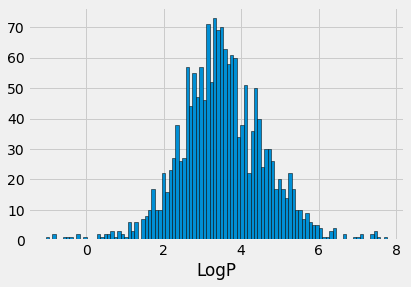

In [13]:
import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.hist(df['logP'].dropna(), bins=100, edgecolor="k")
plt.xlabel("LogP")

Text(0.5, 0, 'AdrA1A_PCHEMBL_VALUE')

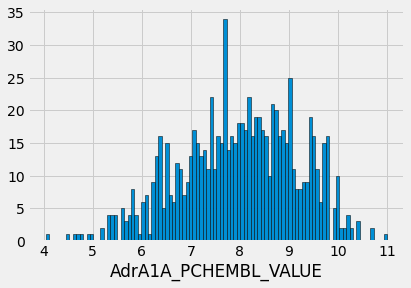

In [14]:
plt.style.use("fivethirtyeight")
plt.hist(df["AdrA1A_PCHEMBL_VALUE"].dropna(), bins=100, edgecolor="k")
plt.xlabel("AdrA1A_PCHEMBL_VALUE")

# "logP" as target value to predict

## Random forest

In [18]:
df1 = df.loc[df.logP.notnull()]
df1.shape

(1731, 328)

In [19]:
labels = [x for x in list(df1["logP"])]


In [20]:
X_features = list(df1["fp"])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

In [22]:
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1)

In [23]:
rf_model = rf.fit(X_train, y_train)

In [24]:
rf_model.score(X_test, y_test)

0.7054135574256659

## SVR

In [25]:
from sklearn.svm import SVR

sv = SVR()
sv_model = sv.fit(X_train, y_train)

In [26]:
sv_model.score(X_test, y_test)

0.5759657362951313

# AdrA1A_PCHEMBL_VALUE as target value to predict

In [27]:
df2 = df.loc[df.AdrA1A_PCHEMBL_VALUE.notnull()]
df2.shape

(841, 328)

In [28]:
X_features = list(df2["fp"])

In [29]:
labels = [str(x) for x in list(df2["AdrA1A_PCHEMBL_VALUE"])]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

In [31]:
rf = RandomForestRegressor(n_estimators=10, max_depth=30, n_jobs=-1)

In [32]:
rf_model = rf.fit(X_train, y_train)

In [33]:
rf_model.score(X_test, y_test)

C:\Users\Diana_Peres\Miniconda3\envs\skill\lib\site-packages\sklearn\metrics\_regression.py:90: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  y_true = check_array(y_true, ensure_2d=False, dtype=dtype)


0.36968145619081116

## GBoost

In [34]:
labels = df2["AdrA1A_PCHEMBL_VALUE"]

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_features, labels, test_size=0.2, random_state=42)

In [36]:
gb = GradientBoostingRegressor(n_estimators=150, learning_rate=0.1, max_depth=3)

In [37]:
gb_model = gb.fit(X_train, y_train)

In [38]:
gb_model.score(X_test, y_test)

0.47441197726301443

In [34]:
def train_GB(est, max_depth, lr):
    gb = GradientBoostingRegressor(n_estimators=est, learning_rate=lr, max_depth= max_depth)
    gb_model = gb.fit(X_train, y_train)
    scr = gb_model.score(X_test, y_test)
    print(f"Est: {est}, Max depth: {max_depth}, Learning rate: {lr} ---- Score: {scr}")

In [35]:
for n_est in [50, 100, 150]:
    for max_depth in [3, 7, 11, 15]:
        for lr in [0.01, 0.1, 1]:
            train_GB(n_est, max_depth, lr)

Est: 50, Max depth: 3, Learning rate: 0.01 ---- Score: 0.24053381357354386
Est: 50, Max depth: 3, Learning rate: 0.1 ---- Score: 0.48064410093889065
Est: 50, Max depth: 3, Learning rate: 1 ---- Score: 0.06085943141076733
Est: 50, Max depth: 7, Learning rate: 0.01 ---- Score: 0.27360327971630893
Est: 50, Max depth: 7, Learning rate: 0.1 ---- Score: 0.3963179433310927
Est: 50, Max depth: 7, Learning rate: 1 ---- Score: 0.09010046119920878
Est: 50, Max depth: 11, Learning rate: 0.01 ---- Score: 0.2749249686269447
Est: 50, Max depth: 11, Learning rate: 0.1 ---- Score: 0.1724679726676872
Est: 50, Max depth: 11, Learning rate: 1 ---- Score: 0.10671691754555601
Est: 50, Max depth: 15, Learning rate: 0.01 ---- Score: 0.26804874769152454
Est: 50, Max depth: 15, Learning rate: 0.1 ---- Score: 0.1815576470880963
Est: 50, Max depth: 15, Learning rate: 1 ---- Score: 0.0324459222632294
Est: 100, Max depth: 3, Learning rate: 0.01 ---- Score: 0.3477605077652247
Est: 100, Max depth: 3, Learning rate: 0